In [86]:
import pandas as pd
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

# SECCION INICIALIZACION DE ARCHIVOS

carpeta = "~/Documents/university/laboratorio_de_datos/TP/"

datos_por_departamento = pd.read_csv(carpeta+"Datos_por_departamento_actividad_y_sexo.csv")
padron_poblacion = pd.read_excel(carpeta+"padron_poblacion.xlsX")
actvidades_establecimiento = pd.read_csv(carpeta+"actividades_establecimientos.csv")
padron_oficial_establecimientos_educativos_2022 = pd.read_csv(carpeta+"2022_padron_oficial_establecimientos_educativos.csv", skiprows=6)

In [103]:
# SECCION LIMPIEZA DE DATOS

# Se crean las tablas o dataframes que modelan el DER construido
modalidad_educativa = pd.DataFrame({
    "id_modalidad": [1, 2, 3, 4, 5, 6, 7],
    "modalidad": ["Común", "Común", "Común", "Común", "Común", "Común", "Común"],
    "sub_modalidad": ["Nivel inicial - Jardín maternal", 
                      "Nivel inicial - Jardín de infantes", "Primario", "Secundario", "Secundario - INET", 
                      "SNU", "SNU - INET"],
    })
establecimiento_educativo = pd.DataFrame(columns=["CUE_establecimiento", "nombre", "sector", "mail", "telefono", "codigo_area"])
establecimiento_modalidad = pd.DataFrame(columns=["CUE_establecimiento", "id_modalidad"])
establecimiento_ubicacion = pd.DataFrame(columns=["CUE_establecimiento", "id_departamento", "ambito", "domicilio", "codigo_postal", "localidad"])
departamento_catalogo = pd.DataFrame(columns=["id_departamento", "id_provincia", "departamento"])
provincia_catalogo = pd.DataFrame(columns=["id_provincia", "provincia"])
actividad_departamento = pd.DataFrame(columns=["id_departamento", "clae6", "genero", "empleo", "establecimiento", "empresas_exportadoras"])
actividad_catalogo = pd.DataFrame(columns=["clae6", "descripcion"])
poblacion_departamento = pd.DataFrame(columns=["id_departamento", "edad", "casos"])


# Se obtienen todos los departamentos con sus provincias y sus ids y se guardan en la tabla catálgo de estos.

query1 = """
        SELECT DISTINCT in_departamentos AS id_departamento, provincia_id AS id_provincia, UPPER(TRANSLATE(departamento, 'áéíóúÁÉÍÓÚäü', 'aeiouAEIOUau')) AS departamento
        FROM datos_por_departamento;
"""

departamento_catalogo = db.query(query1).to_df()

# La tabla catálogo se va a utilizar para matchear consultas con las 3 entidades con las que se relaciona como se ve en el der
# Sin embargo este departamento no se estaba incluido en la consulta anterior (pero sí en EE) por lo cual se lo agrega.

temp = pd.DataFrame({
        "id_departamento": [99999],
        "id_provincia": [94],
        "departamento": ['ANTARTIDA ARGENTINA']
    })

departamento_catalogo = pd.concat([departamento_catalogo, temp], ignore_index=True)

# Se completa la tabla provincia catalogo de manera análoga a la de departamento catálogo.

query2 = """
        SELECT DISTINCT provincia_id AS id_provincia, UPPER(provincia) AS provincia 
        FROM datos_por_departamento;
"""

provincia_catalogo = db.query(query2).to_df()

# Se completa la tabla de actividad catálogo.

query3 = """
        SELECT DISTINCT clae6, clae6_desc FROM actvidades_establecimiento;
"""

actividad_catalogo = db.query(query3).to_df()

# Hacemos una prelimpieza de una de las tablas crudas, primero se descartan las columnas que no son de interés (modalidades educativas más allá de la común)
# y se definen nombres de columna correctos que interpretan la columna compuesta con la que se presentaba el excel.

query4 = """
        SELECT "Jurisdicción", "Cueanexo", "Nombre", "Sector", "Ámbito", "Domicilio", "C. P.", "Código de área", "Teléfono", "Código de localidad", "Localidad", "Departamento", "Mail", 
        "Nivel inicial - Jardín maternal" AS "Comun-Nivel inicial - Jardín maternal", "Nivel inicial - Jardín de infantes" AS "Comun-Nivel inicial - Jardín de infantes",
        "Primario" AS "Comun-Primario", "Secundario" AS "Comun-Secundario", "Secundario - INET" AS "Comun-Secundario - INET", "SNU" AS "Comun-SNU", "SNU - INET" AS "Comun-SNU - INET"
        FROM padron_oficial_establecimientos_educativos_2022;
"""

padron_oficial_establecimientos_educativos_2022 = db.query(query4).to_df()

# Se completa la tabla de EE del DER que resulta simplemente una view o proyección de las columnas que se tomaron en la anterior query.

query5 = """
        SELECT "Cueanexo" AS "CUE_establecimiento", "Nombre" AS "nombre", "Sector" AS "sector", "Mail" AS "mail", "Teléfono" AS "telefono",
        "Código de área" AS "codigo_area" FROM padron_oficial_establecimientos_educativos_2022
"""


establecimiento_educativo = db.query(query5).to_df()

# Se extrae la información de la tabla cruda de EE sobre las modalidades educativas de cada institución para plasmarlas en una nueva identidad, 
# para ello, como se ve en la query, se utiliza varias veces el operador UNION y se van seleccionando aquellas entradas que no son nulas o vacias para
# cada categoría.

query6 = """
        SELECT "Cueanexo" AS "CUE_establecimiento", 1 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-Nivel inicial - Jardín maternal") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 2 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-Nivel inicial - Jardín de infantes") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 3 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-Primario") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 4 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-Secundario") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 5 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-Secundario - INET") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 6 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-SNU") != ''
        UNION
        SELECT "Cueanexo" AS "CUE_establecimiento", 7 AS "id_modalidad" FROM padron_oficial_establecimientos_educativos_2022 WHERE TRIM("Comun-SNU - INET") != ''
        """

establecimiento_modalidad = db.query(query6).to_df()

# Como ya se explicó y se deja entender por el DER, nos interesa utilizar la tabla de departamento catálogo como punto de "pivot" para poder relacionar las
# distintas tablas en las consultas. Ahora bien, la tabla EE cruda, a diferencia de las otras no cuenta con el id del departamento por lo cual se intenta
# matchar por nombre departamento + nombre provincia (ya que esta combinación es única, pues en una misma provincia no existen dos o más departamentos con 
# el mismo nombre). 

query7 = """
        SELECT "Cueanexo" AS "CUE_establecimiento", departamento.id_departamento, "Ámbito" AS "ambito", "Domicilio" AS "domicilio", "C. P." AS "codigo_postal", "Localidad" AS "localidad" 
        FROM padron_oficial_establecimientos_educativos_2022 establecimiento
        LEFT JOIN (SELECT id_departamento, departamento, 
                   CASE 
                   WHEN prov.provincia = 'CABA' THEN 'CIUDAD DE BUENOS AIRES' 
                   ELSE prov.provincia 
                   END AS provincia FROM departamento_catalogo departamento
                   INNER JOIN provincia_catalogo prov ON departamento.id_provincia = prov.id_provincia) departamento
        ON UPPER(TRANSLATE(establecimiento.Departamento, 'áéíóúÁÉÍÓÚäü', 'aeiouAEIOUau')) = departamento.departamento 
        AND UPPER(TRANSLATE(establecimiento."Jurisdicción", 'áéíóúÁÉÍÓÚäü', 'aeiouAEIOUau')) = departamento.provincia 
"""

establecimiento_ubicacion = db.query(query7).to_df()

# Usando el método anterior era imposible resolver todos los departamentos. Esto se debe a diferencias en la escritura de los departamentos como
# abreviaciones, (general, grl. doctor, dr., etc) y recortes del nombre, entre otras. Afortunadamente son relativamente acotadas las ocurrencias que no 
# consiguieron hacer match en el join y se resuelven manualmente.

query8 = """
        SELECT a.CUE_establecimiento, 
        CASE
        WHEN id_departamento IS NOT NULL THEN id_departamento
        WHEN b.Departamento = 'CORONEL FELIPE VARELA' THEN 46028
        WHEN b.Departamento = 'LIBERTADOR GRL SAN MARTIN' THEN 54077
        WHEN b.Departamento = 'JUAN F IBARRA' THEN 86098
        WHEN b.Departamento = 'GENERAL ANGEL V PEÑALOZA' THEN 46056
        WHEN b.Departamento = 'JUAN B ALBERDI' THEN 90042
        WHEN b.Departamento = '1§ DE MAYO' THEN 22126
        WHEN b.Departamento = 'GENERAL JUAN MARTIN DE PUEYRREDON' THEN 74056
        WHEN b.Departamento = 'MAYOR LUIS J FONTANA' THEN 22098
        WHEN b.Departamento = 'DOCTOR MANUEL BELGRANO' THEN 38021
        WHEN b.Departamento = 'GENERAL JUAN F QUIROGA' THEN 46070
        WHEN b.Departamento = 'CORONEL DE MARINA L ROSALES' THEN 6182
        WHEN b.Departamento = 'O HIGGINS' THEN 22112
        WHEN b.Departamento = 'GENERAL OCAMPO' THEN 46084
        WHEN b.Departamento = 'ANTARTIDA ARGENTINA' THEN 99999
        END AS id_departamento
        , a.ambito, a.domicilio, a.codigo_postal, a.localidad FROM establecimiento_ubicacion a
        INNER JOIN  padron_oficial_establecimientos_educativos_2022 b ON a.CUE_establecimiento = b.Cueanexo
"""

establecimiento_ubicacion = db.query(query8).to_df()

# Se limpia / parsea el excel de población que se encontraba de una manera bastante extraña, ciclando a través de sus filas, para obtener una sola tabla.

def parsearExcelPoblacion(df):
    filas_validas = []
    departamento_actual = ""
    id_departamento_actual = ""

    for i in range(len(df)):
       fila = df.iloc[i]

       columna_0 = str(fila[0])
       columna_1 = str(fila[1])
       columna_2 = str(fila[2])
       columna_3 = str(fila[3])
       columna_4 = str(fila[4])
    

       # Veo si en la columna 1 de cada fila aparece "#"
       if "#" in columna_1:
           departamento_actual = columna_2
           id = columna_1.split('#')[1].strip()
           id_departamento_actual = int(id.lstrip('0'))
           continue
       
       # Si se llega al final de las filas válidas se termina el ciclo
       if "RESUMEN" in columna_1:
           break
       
   
       #Salto las filas que estan vacias
       if ((columna_0 == "" or columna_0 == "nan") and
           (columna_1 == "" or columna_1 == "nan") and
           (columna_2 == "" or columna_2 == "nan") and
           (columna_3 == "" or columna_3 == "nan") and
           (columna_4 == "" or columna_4 == "nan")):
           continue
       
       def es_numero(texto):
           texto = texto.replace(",", ".")
           return texto.replace(".", "").isdigit()
       
       # Verifico si las columnas 1–4 son numéricas
       if es_numero(columna_1) and es_numero(columna_2) and es_numero(columna_3) and es_numero(columna_4):
           edad = int(columna_1)
           casos = int(columna_2)
           porcentaje = float(columna_3.replace(",", "."))
           acumulado = float(columna_4.replace(",", "."))
           
           filas_validas.append((id_departamento_actual, departamento_actual, edad, casos, porcentaje, acumulado))    
    return pd.DataFrame(filas_validas, columns=["id_departamento", "Departamento", "Edad", "Casos", "Porcentaje", "Acumulado_Porcentaje"])

poblacion_departamento = parsearExcelPoblacion(padron_poblacion)

# Nuevamente como en el caso de EE, algunos departamentos terminan no matcheando, y se corrijen individualmente.

query9 = """
        SELECT 
        CASE 
        WHEN pob.id_departamento = 94015 THEN 94014
        WHEN pob.id_departamento = 6218 THEN 6217
        WHEN pob.id_departamento = 94008 THEN 94007
        ELSE pob.id_departamento
        END AS id_departamento, 
        "Edad" AS "edad", "Casos" AS "casos" FROM poblacion_departamento pob
"""
poblacion_departamento = db.query(query9).to_df()

# Se proyectan algunas columnas de la tabla cruda de actividades de empresas para que coincida con la representada en el DER.


query10 = """
        SELECT in_departamentos AS "id_departamento", clae6, genero, Empleo AS "empleo", 
        "Establecimientos" AS "establecimiento", empresas_exportadoras FROM datos_por_departamento
        WHERE anio = 2022
"""

actividad_departamento = db.query(query10).to_df()

/tmp/ipykernel_1013212/3287578429.py:159: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  columna_0 = str(fila[0])
/tmp/ipykernel_1013212/3287578429.py:160: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  columna_1 = str(fila[1])
/tmp/ipykernel_1013212/3287578429.py:161: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  columna_2 = str(fila[2])
/tmp/ipykernel_1013212/3287578429.py:162: FutureWarning: Series.__getitem__ treating keys as posi

In [117]:
# SECCION QUERIES

# Se hace la consulta sobre la tabla departamento y luego se hacen joins sobre las subqueries que procesaron los datos pedidos por medio de la función de 
# agregación SUM.

res_query1 = """
        SELECT prov.provincia, dep.departamento, est_ed.Jardines, pob.casos_jardin AS "Población Jardín",
        est_ed.Primario, pob.casos_primaria AS "Población Primaria", est_ed.Secundario, pob.casos_secundario AS "Población Secundario",
        est_ed."Superior no Universitaria", pob.casos_SNU AS "Población Superior no Universitaria"
        FROM departamento_catalogo dep
        INNER JOIN provincia_catalogo prov ON dep.id_provincia = prov.id_provincia
        LEFT JOIN (SELECT
                   est_ub.id_departamento,
                   SUM(CASE WHEN mod_cat.sub_modalidad LIKE '%Jardín%' THEN 1 ELSE 0 END) AS 'Jardines',
                   SUM(CASE WHEN mod_cat.sub_modalidad LIKE '%Primario%' THEN 1 ELSE 0 END) AS 'Primario',
                   SUM(CASE WHEN mod_cat.sub_modalidad LIKE '%Secundario%' THEN 1 ELSE 0 END) AS 'Secundario',
                   SUM(CASE WHEN mod_cat.sub_modalidad LIKE '%SNU%' THEN 1 ELSE 0 END) AS 'Superior no Universitaria'
                   FROM establecimiento_ubicacion est_ub
                   INNER JOIN establecimiento_modalidad est_mod ON est_ub.CUE_establecimiento = est_mod.CUE_establecimiento
                   INNER JOIN modalidad_educativa mod_cat ON est_mod.id_modalidad = mod_cat.id_modalidad
                   GROUP BY est_ub.id_departamento
                  ) est_ed ON dep.id_departamento = est_ed.id_departamento
        LEFT JOIN (SELECT
                   id_departamento,
                   SUM(CASE WHEN edad >= 2 AND edad <= 5 THEN casos ELSE 0 END) AS "casos_jardin",
                   SUM(CASE WHEN edad >= 6 AND edad <= 11 THEN casos ELSE 0 END) AS "casos_primaria",
                   SUM(CASE WHEN edad >= 12 AND edad <= 17 THEN casos ELSE 0 END) AS "casos_secundario",
                   SUM(CASE WHEN edad >= 18 AND edad <= 21 THEN casos ELSE 0 END) AS "casos_SNU"
                   FROM poblacion_departamento
                   GROUP BY id_departamento) pob ON dep.id_departamento = pob.id_departamento
        WHERE est_ed.Jardines IS NOT NULL AND pob.casos_jardin IS NOT NULL
        ORDER BY prov.provincia, est_ed.Jardines DESC
"""

result1 = db.query(res_query1).to_df()

# Se obtienen los departamentos y la cantidad de empleos haciendo un simple join entre estas tablas.


res_query2 = """
        SELECT prov.provincia, dep.departamento, empleo AS "Cantidad total de empleados en 2022"
        FROM departamento_catalogo dep
        INNER JOIN provincia_catalogo prov ON dep.id_provincia = prov.id_provincia
        LEFT JOIN (SELECT id_departamento, SUM(empleo) AS empleo 
                   FROM actividad_departamento
                   GROUP BY id_departamento) act
        ON dep.id_departamento = act.id_departamento
        ORDER BY prov.provincia ASC, empleo DESC
"""

result2 = db.query(res_query2).to_df()

# Se seleccionan los departamentos y luego se hacen los joins con las tablas de actividad y población utilizando la función de agregación
# SUM en cada caso para obtener lo pedido.

res_query3 = """
        SELECT prov.provincia, dep.departamento, act.expo_mujeres AS "Cant_Expo_Mujeres", 
        est_EE.cant_EE AS "Cant_EE", pob.poblacion
        FROM departamento_catalogo dep
        INNER JOIN provincia_catalogo prov ON dep.id_provincia = prov.id_provincia
        LEFT JOIN (SELECT id_departamento, 
                   SUM(CASE WHEN genero LIKE '%Mujer%' THEN empresas_exportadoras ELSE 0 END) AS expo_mujeres,
                   SUM(empresas_exportadoras) AS expo_comun 
                   FROM actividad_departamento
                   GROUP BY id_departamento) act
        ON dep.id_departamento = act.id_departamento
        LEFT JOIN (SELECT
                   id_departamento,
                   SUM(casos) AS poblacion
                   FROM poblacion_departamento
                   GROUP BY id_departamento) pob 
        ON dep.id_departamento = pob.id_departamento
        LEFT JOIN (SELECT
                   id_departamento,
                   COUNT(CUE_Establecimiento) AS cant_EE
                   FROM establecimiento_ubicacion est_ub
                   GROUP BY id_departamento) est_EE
        ON dep.id_departamento = est_EE.id_departamento
        ORDER BY "Cant_EE" DESC, provincia ASC, departamento DESC
"""

result3 = db.query(res_query3).to_df()

# Las primeras 3 subqueries seleccionan: la cantidad de empleos en cada provincia, la cantidad de departamentos en cada provincia y la cantidad de empleos
# en cada departamento. Finalmente la última subquery selecciona la clae6 por departamento que maximiza la cantidad de empleos. Luego el resultado final 
# filtra por los departamentos que superan el promedio computado y se ordena los resultados de acuerdo a las provincias.

res_query4 = """
                SELECT prov.provincia, empleos_departamento.departamento, 
                LEFT(CAST(departamento_max_clae6.clae6 AS VARCHAR), 3) AS clae3,
                departamento_max_clae6.empleo AS "Cant. empleos"
                FROM
                (
                    SELECT id_provincia, SUM(empleo) AS empleo 
                    FROM actividad_departamento act
                    INNER JOIN departamento_catalogo dep ON act.id_departamento = dep.id_departamento
                    GROUP BY id_provincia
                ) empleos_provincia
                INNER JOIN 
                (
                    SELECT prov.id_provincia, count(*) AS cantidad_departamentos
                    FROM departamento_catalogo dep
                    INNER JOIN provincia_catalogo prov ON dep.id_provincia = prov.id_provincia
                    GROUP BY prov.id_provincia
                ) departamentos_provincia
                ON empleos_provincia.id_provincia = departamentos_provincia.id_provincia
                INNER JOIN 
                (
                    SELECT dep.id_provincia, dep.id_departamento, dep.departamento, SUM(empleo) AS empleo_departamento 
                    FROM actividad_departamento act
                    INNER JOIN departamento_catalogo dep ON act.id_departamento = dep.id_departamento
                    GROUP BY dep.id_departamento, dep.id_provincia, dep.departamento
                ) empleos_departamento
                ON empleos_provincia.id_provincia = empleos_departamento.id_provincia
                INNER JOIN
                (
                    SELECT max_empleo_clae6.id_departamento AS id_departamento, empleo_clae6.clae6 AS clae6, max_empleo_clae6.empleo AS empleo
                    FROM 
                    (SELECT id_departamento, MAX(empleo) AS empleo FROM 
                        (SELECT act.id_departamento, act.clae6, SUM(act.empleo) AS empleo
                        FROM actividad_departamento act
                        GROUP BY act.id_departamento, act.clae6) 
                    GROUP BY id_departamento) max_empleo_clae6
                    INNER JOIN 
                        (SELECT act.id_departamento, act.clae6, SUM(act.empleo) AS empleo
                        FROM actividad_departamento act
                        GROUP BY act.id_departamento, act.clae6) empleo_clae6
                    ON max_empleo_clae6.empleo = empleo_clae6.empleo AND max_empleo_clae6.id_departamento = empleo_clae6.id_departamento
                ) departamento_max_clae6
                ON empleos_departamento.id_departamento = departamento_max_clae6.id_departamento
                INNER JOIN provincia_catalogo prov ON empleos_provincia.id_provincia = prov.id_provincia
                WHERE empleos_departamento.empleo_departamento > empleos_provincia.empleo / departamentos_provincia.cantidad_departamentos
                ORDER BY provincia DESC
"""

result4 = db.query(res_query4).to_df()

display(result1)
display(result2)
display(result3)
display(result4)


,provincia,departamento,Jardines,Población Jardín,Primario,Población Primaria,Secundario,Población Secundario,Superior no Universitaria,Población Superior no Universitaria
0,BUENOS AIRES,LA MATANZA,378.0,113641.0,333.0,193043.0,352.0,184423.0,25.0,113130.0
1,BUENOS AIRES,LA PLATA,274.0,37646.0,199.0,66893.0,219.0,65622.0,64.0,51590.0
2,BUENOS AIRES,GENERAL PUEYRREDON,229.0,29666.0,169.0,53294.0,179.0,56683.0,46.0,39001.0
3,BUENOS AIRES,QUILMES,203.0,34636.0,146.0,60261.0,163.0,60966.0,18.0,38247.0
4,BUENOS AIRES,LOMAS DE ZAMORA,201.0,37017.0,178.0,65571.0,205.0,65827.0,34.0,40165.0
...,...,...,...,...,...,...,...,...,...,...
520,TUCUMAN,FAMAILLA,25.0,2979.0,23.0,4753.0,18.0,4570.0,5.0,3154.0
521,TUCUMAN,TAFI DEL VALLE,25.0,1326.0,24.0,2270.0,16.0,2092.0,4.0,1472.0
522,TUCUMAN,TRANCAS,25.0,1522.0,25.0,2451.0,19.0,2433.0,4.0,1766.0
523,TUCUMAN,JUAN BAUTISTA ALBERDI,19.0,2023.0,19.0,3478.0,15.0,3547.0,1.0,2246.0


,provincia,departamento,Cantidad total de empleados en 2022
0,BUENOS AIRES,LA MATANZA,127962.0
1,BUENOS AIRES,VICENTE LOPEZ,120347.0
2,BUENOS AIRES,GENERAL PUEYRREDON,118660.0
3,BUENOS AIRES,SAN ISIDRO,98372.0
4,BUENOS AIRES,LA PLATA,89699.0
...,...,...,...
523,TUCUMAN,BURRUYACU,965.0
524,TUCUMAN,TRANCAS,828.0
525,TUCUMAN,LA COCHA,784.0
526,TUCUMAN,TAFI DEL VALLE,629.0


,provincia,departamento,Cant_Expo_Mujeres,Cant_EE,poblacion
0,CORDOBA,CAPITAL,1296.0,1400,1498060.0
1,SANTA FE,ROSARIO,1425.0,1248,1337958.0
2,BUENOS AIRES,LA MATANZA,864.0,1186,1837168.0
3,BUENOS AIRES,LA PLATA,233.0,832,756074.0
4,CHACO,SAN FERNANDO,200.0,810,413764.0
...,...,...,...,...,...
523,CHUBUT,MARTIRES,0.0,3,744.0
524,LA RIOJA,SANAGASTA,0.0,3,2994.0
525,TIERRA DEL FUEGO,TOLHUIN,6.0,1,6027.0
526,TIERRA DEL FUEGO,ANTARTIDA ARGENTINA,NaN,1,NaN


,provincia,departamento,clae3,Cant. empleos
0,TUCUMAN,CAPITAL,161,13863.0
1,TUCUMAN,YERBA BUENA,161,2923.0
2,TUCUMAN,CRUZ ALTA,161,2392.0
3,TIERRA DEL FUEGO,RIO GRANDE,264,2770.0
4,TIERRA DEL FUEGO,USHUAIA,264,3076.0
...,...,...,...,...
106,BUENOS AIRES,EZEIZA,511,3071.0
107,BUENOS AIRES,LUJAN,851,1169.0
108,BUENOS AIRES,QUILMES,851,6848.0
109,BUENOS AIRES,VICENTE LOPEZ,801,11368.0


/tmp/ipykernel_1013212/3333745126.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


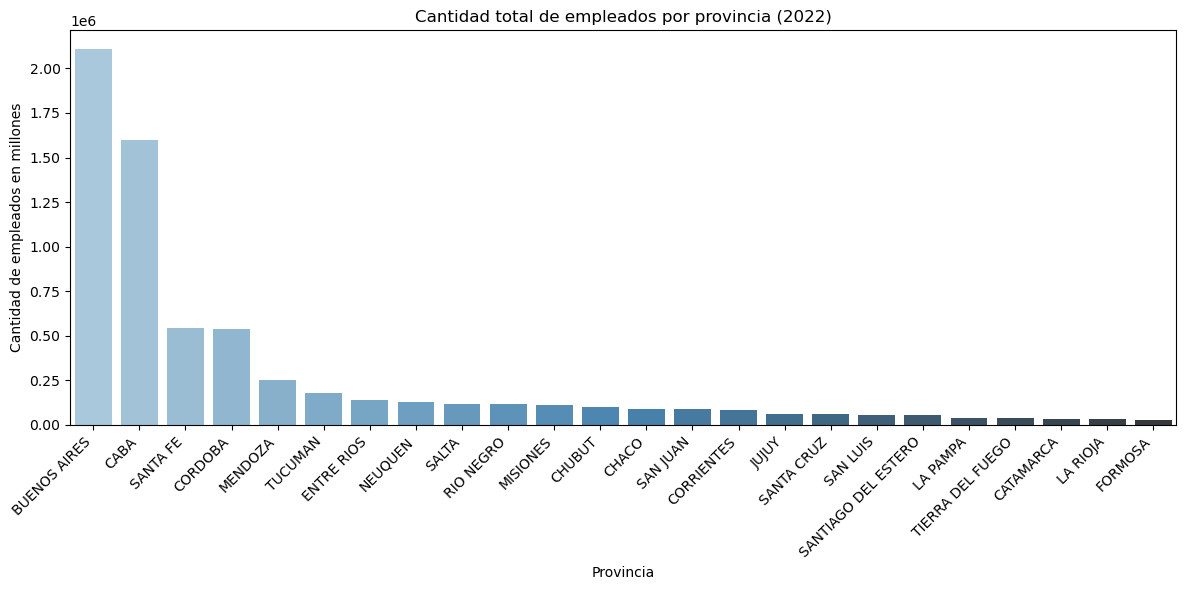

/tmp/ipykernel_1013212/3333745126.py:49: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figureEE.show()


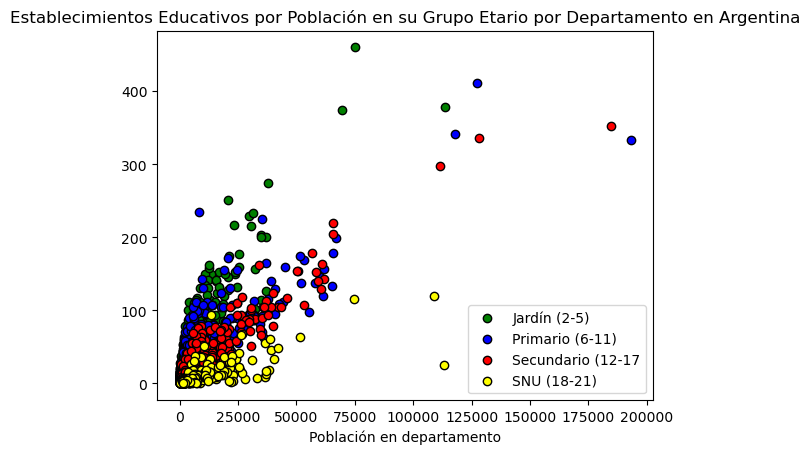

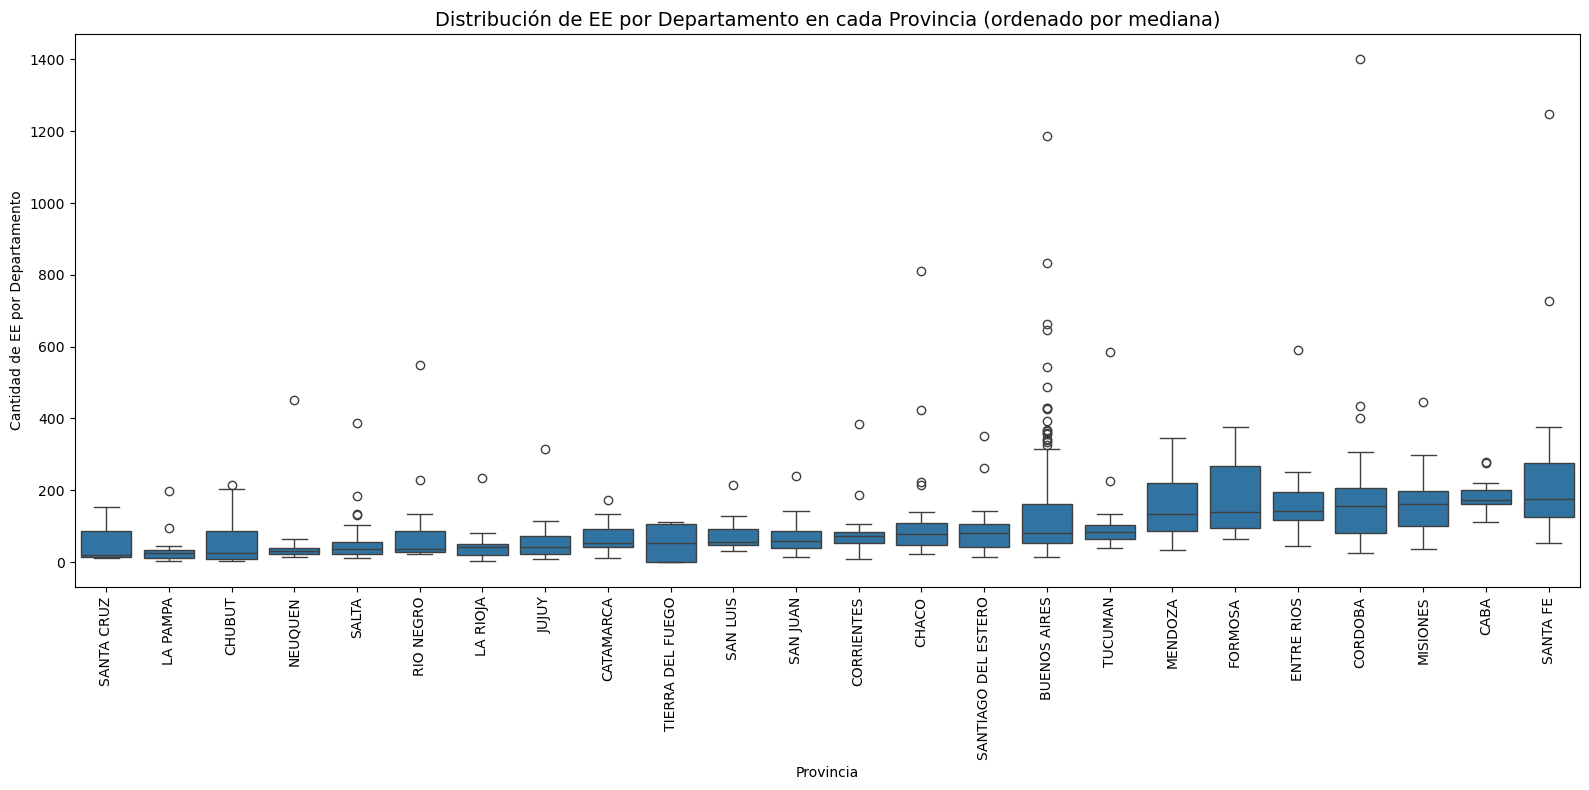

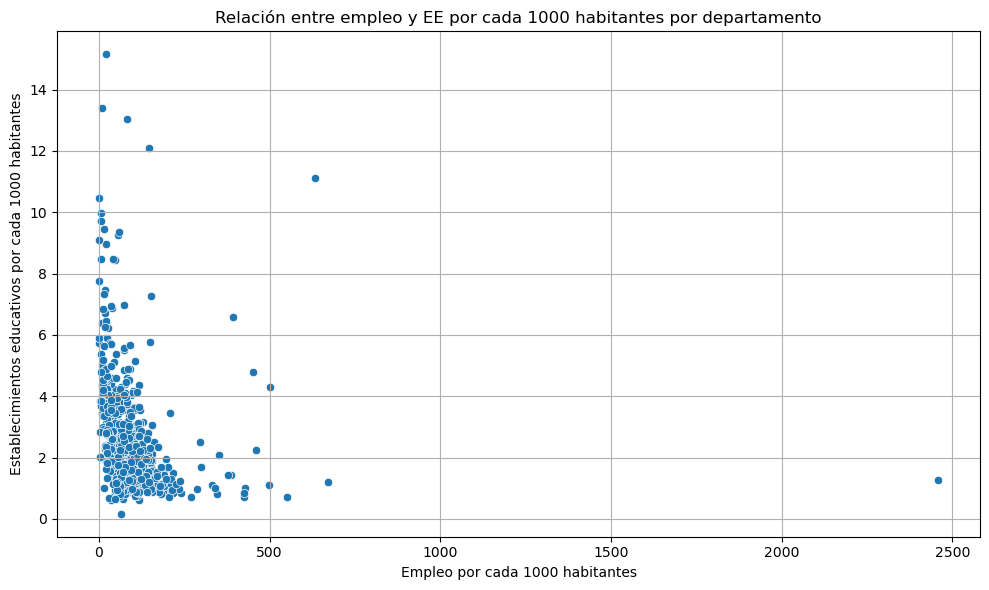

/tmp/ipykernel_1013212/3333745126.py:158: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_1013212/3333745126.py:178: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


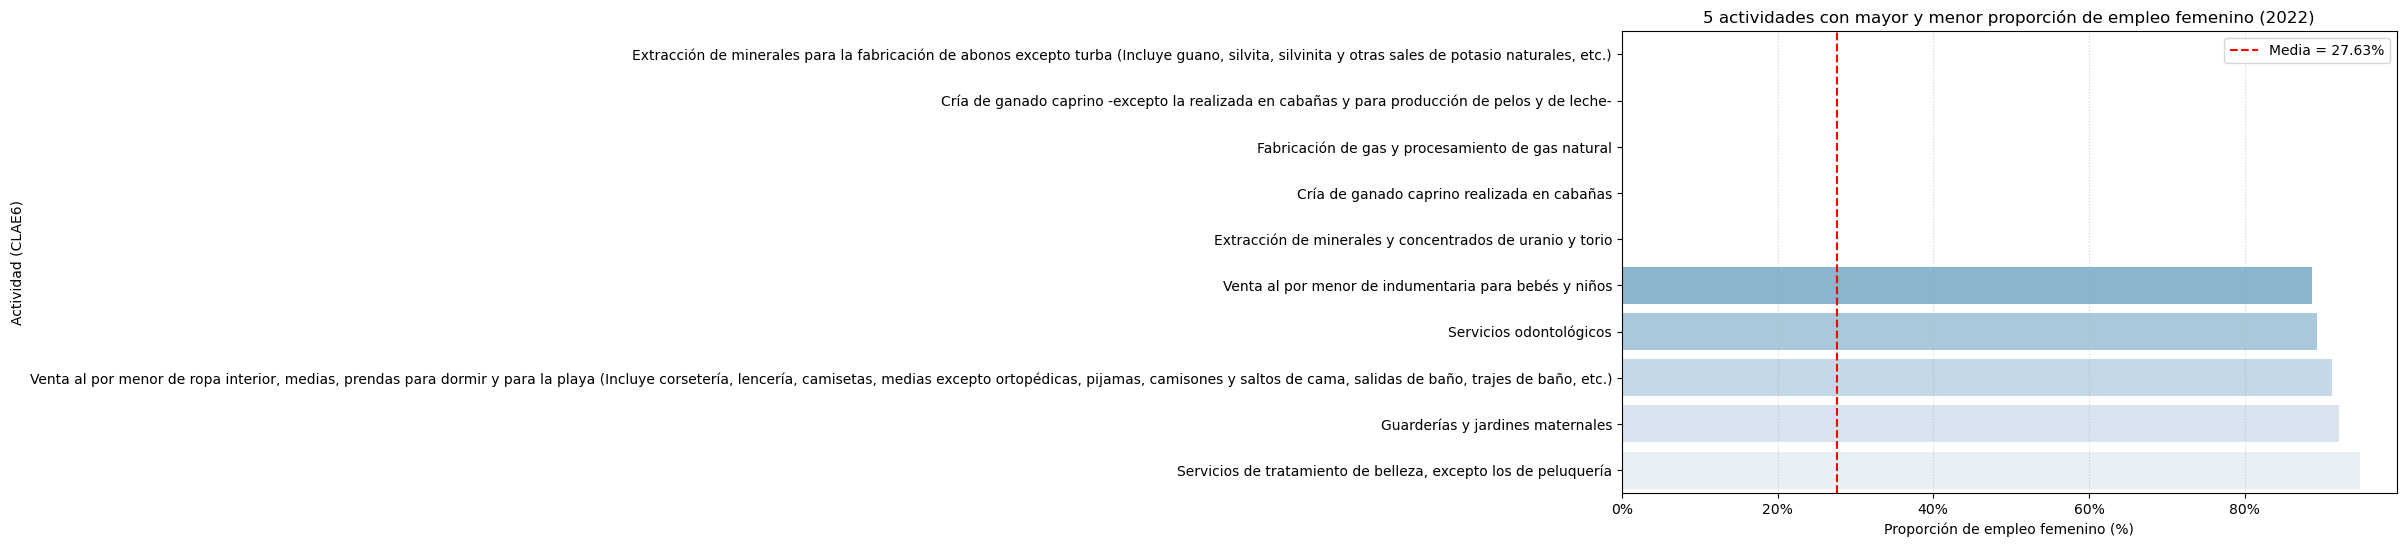

In [114]:
# SECCION ANALISIS VISUAL DE DATOS

#1) 
query_empleo_prov = """
    SELECT
      prov.provincia,
      SUM(act.empleo) AS empleo_total
    FROM actividad_departamento act
    JOIN departamento_catalogo dep ON act.id_departamento = dep.id_departamento
    JOIN provincia_catalogo prov ON dep.id_provincia = prov.id_provincia
    GROUP BY prov.provincia
    ORDER BY empleo_total DESC
"""

df_empleo_prov = db.query(query_empleo_prov).to_df()

# Grafico
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_empleo_prov,
    x='provincia',
    y='empleo_total',
    palette='Blues_d'
)
plt.title('Cantidad total de empleados por provincia (2022)')
plt.xlabel('Provincia')
plt.ylabel('Cantidad de empleados en millones')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

#2)
figureEE, axEE = plt.subplots()

axEE.scatter(data=result1, x='Población Jardín', y='Jardines', c='green'
           , edgecolor='k', label='Jardín (2-5)')
axEE.scatter(data=result1, x='Población Primaria', y='Primario', c='blue'
           ,edgecolor='k', label='Primario (6-11)')
axEE.scatter(data=result1, x='Población Secundario', y='Secundario', c='red'
           , edgecolor='k', label='Secundario (12-17')
axEE.scatter(data=result1, x='Población Superior no Universitaria', y='Superior no Universitaria', c='yellow'
           , edgecolor='k', label='SNU (18-21)')

axEE.set_title('Establecimientos Educativos por Población en su Grupo Etario por Departamento en Argentina')
axEE.set_xlabel('Población en departamento')
#axEE.set_ylabel('Cantidad de EE en departamento')
#axEE.set_ylim(0, 500)
axEE.legend()
figureEE.show()

#3) 
# Consulta para obtener cantidad de EE por departamento y provincia
query_boxplot = """
SELECT 
    p.provincia,
    d.departamento,
    COUNT(DISTINCT ee.CUE_establecimiento) AS cantidad_EE
FROM establecimiento_ubicacion ee
JOIN departamento_catalogo d ON ee.id_departamento = d.id_departamento
JOIN provincia_catalogo p ON d.id_provincia = p.id_provincia
GROUP BY p.provincia, d.departamento
"""


df_boxplot = db.query(query_boxplot).to_df()

# Ordena provincias por mediana de cantidad_EE para que los boxplots estén ordenados
orden_provincias = (
    df_boxplot.groupby('provincia')['cantidad_EE']
    .median()
    .sort_values()
    .index
)

df_boxplot['provincia'] = pd.Categorical(
    df_boxplot['provincia'],
    categories=orden_provincias,
    ordered=True
)

#4)
#Grafico
fig, ax = plt.subplots(figsize=(16, 8))

sns.boxplot(
    data=df_boxplot,
    x='provincia',
    y='cantidad_EE',
    ax=ax
)

ax.set_title('Distribución de EE por Departamento en cada Provincia (ordenado por mediana)', fontsize=14)
ax.set_xlabel('Provincia')
ax.set_ylabel('Cantidad de EE por Departamento')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


query_relacion = """
    SELECT dep_emp.provincia, dep_emp.departamento, dep_emp."Cantidad total de empleados en 2022",
    dep_EE.Cant_EE, dep_EE.poblacion, ((dep_emp."Cantidad total de empleados en 2022" * 1000.0) / dep_EE.poblacion) AS empleados_por_1000,
    ((dep_EE.Cant_EE * 1000.0) / dep_EE.poblacion) AS EE_por_1000 FROM result2 dep_emp
    INNER JOIN result3 dep_EE
    ON dep_emp.provincia = dep_EE.provincia AND dep_emp.departamento = dep_EE.departamento
    ORDER BY Cant_EE DESC
"""



df_relacion = db.query(query_relacion).to_df()

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_relacion,
    x='empleados_por_1000',
    y='EE_por_1000'
)
plt.title('Relación entre empleo y EE por cada 1000 habitantes por departamento')
plt.xlabel('Empleo por cada 1000 habitantes')
plt.ylabel('Establecimientos educativos por cada 1000 habitantes')
#plt.ylim(0, 6)
#plt.xlim(0, 500)
plt.grid(True)
plt.tight_layout()
plt.show()


#5)
query_genero = """
SELECT
  a.clae6,
  c.clae6_desc,
  SUM(CASE WHEN a.genero LIKE '%Mujer%' THEN a.empleo ELSE 0 END) AS empleo_mujer,
  SUM(a.empleo) AS empleo_total,
  SUM(CASE WHEN a.genero LIKE '%Mujer%' THEN a.empleo ELSE 0 END) * 1.0 / SUM(a.empleo) AS proporcion_mujer
FROM actividad_departamento a
JOIN actividad_catalogo c ON a.clae6 = c.clae6
WHERE a.empleo IS NOT NULL
GROUP BY a.clae6, c.clae6_desc
HAVING SUM(a.empleo) > 0
"""

df_genero = db.query(query_genero).to_df()


df_sort = df_genero.sort_values('proporcion_mujer', ascending=False)
top5 = df_sort.head(5)
bottom5 = df_sort.tail(5)
df_plot = pd.concat([top5, bottom5])

# Calcular promedio
media_proporcion = df_genero['proporcion_mujer'].mean()


plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_plot.sort_values('proporcion_mujer', ascending=True),  # ordena visualmente de menor a mayor
    y='clae6_desc',
    x='proporcion_mujer',
    palette='Blues_r'
)

# Línea del promedio
plt.axvline(media_proporcion, color='red', linestyle='--', label=f'Media = {media_proporcion:.2%}')

# Ajustes estéticos
plt.title('5 actividades con mayor y menor proporción de empleo femenino (2022)', fontsize=12)
plt.xlabel('Proporción de empleo femenino (%)')
plt.ylabel('Actividad (CLAE6)')
plt.legend()
plt.grid(axis='x', linestyle=':', alpha=0.6)

# Mostrar valores en porcentaje
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))

plt.tight_layout()
plt.show()